In [1]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

In [2]:
# -----------
# Graded Cell
# -----------
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    
    Because the argmax function returns the first instance of the 
    highest value, this is why we need to record all top value index
    and randomly choice one
    """
    top_value = float("-inf")
    ties = []
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties=[]
        if q_values[i] == top_value:
            ties.append(i)
        #raise NotImplementedError()
    return np.random.choice(ties)

In [5]:
# -----------
# Graded Cell
# -----------
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        #######################
        
        # Update Q values Hint: Look at the algorithm in section 2.4 of the textbook.
        # increment the counter in self.arm_count for the action from the previous time step
        # update the step size using self.arm_count
        # update self.q_values for the action from the previous time step
        
        # YOUR CODE HERE
        self.arm_count[self.last_action] += 1
        #raise NotImplementedError()
 
        # Use the argmax function you created above
        # YOUR CODE HERE
        current_action = argmax(self.q_values)
        #raise NotImplementedError()
        
        step_size = 1 / self.arm_count[self.last_action]
        
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size * (reward - self.q_values[self.last_action])
        
        self.last_action = current_action
        
        return current_action
        

100%|██████████| 200/200 [00:03<00:00, 58.11it/s]


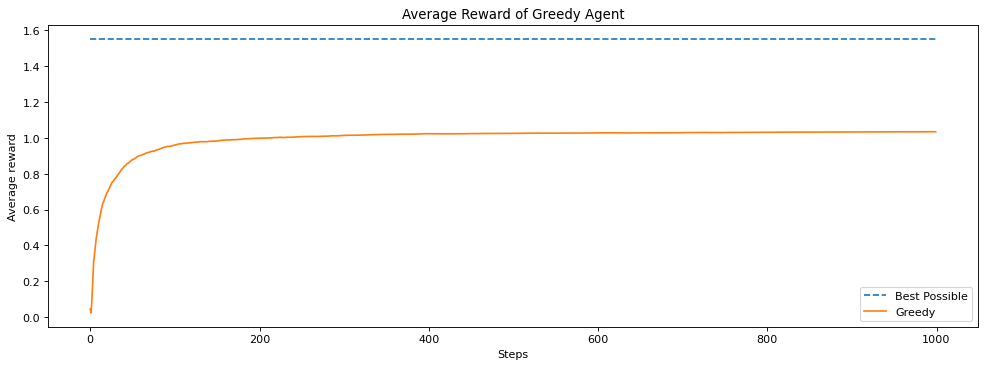

In [8]:
# ---------------
# Discussion Cell
# ---------------

num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

all_averages = []

average_best = 0
for run in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

In [9]:
# -----------
# Graded Cell
# -----------
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
       

        # Update Q values - this should be the same update as your greedy agent above
        self.arm_count[self.last_action] += 1
        step_size = 1 / self.arm_count[self.last_action]
        self.q_values[self.last_action] = self.q_values[self.last_action] + step_size * (reward - self.q_values[self.last_action])

        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon
        # (hint: look at np.random.random()). If it is, set current_action to a random action.
        # otherwise choose current_action greedily as you did above.
        
        if np.random.random(1) < self.epsilon:
            current_action = np.random.choice( range(len(self.arm_count)) )
        else:
            current_action = argmax(self.q_values)
        
        self.last_action = int(current_action)
        
        return current_action

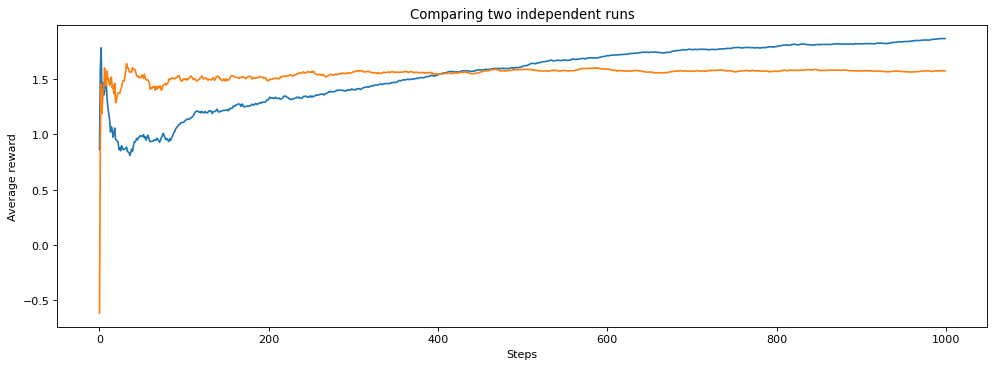

In [13]:
# ---------------
# Discussion Cell
# ---------------

# Plot runs of e-greedy agent
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": 0.1}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run) # Here we set the seed so that we can compare two different runs
    averages = []
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    
    plt.plot(averages)

plt.title("Comparing two independent runs")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

100%|██████████| 200/200 [00:07<00:00, 28.15it/s]


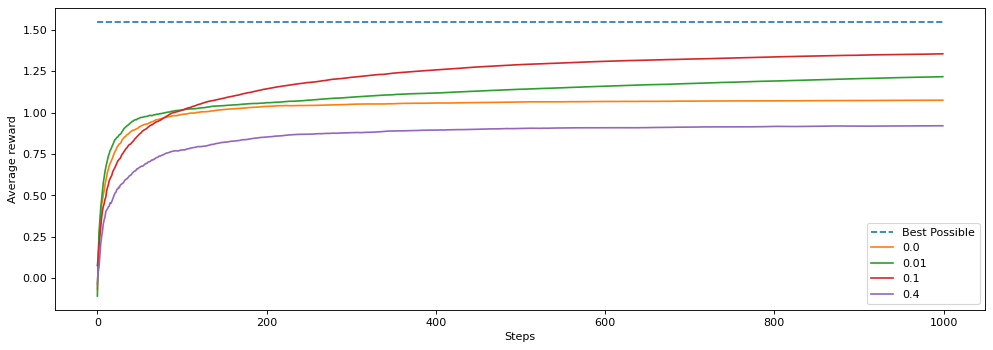

In [16]:
# ---------------
# Discussion Cell
# ---------------

# Experiment code for different e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

In [17]:
# -----------
# Graded Cell
# -----------
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : An int of the action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        # YOUR CODE HERE
        self.q_values[self.last_action] = self.q_values[self.last_action] + self.step_size * (reward - self.q_values[self.last_action])
    
        
        # Choose action using epsilon greedy. This is the same as you implemented above.
        if np.random.random(1) < self.epsilon:
            current_action = np.random.choice(range(len(self.arm_count)))
        else:
            current_action = argmax(self.q_values)
        
        
        self.last_action = current_action
        
        return current_action

100%|██████████| 200/200 [00:07<00:00, 28.43it/s]


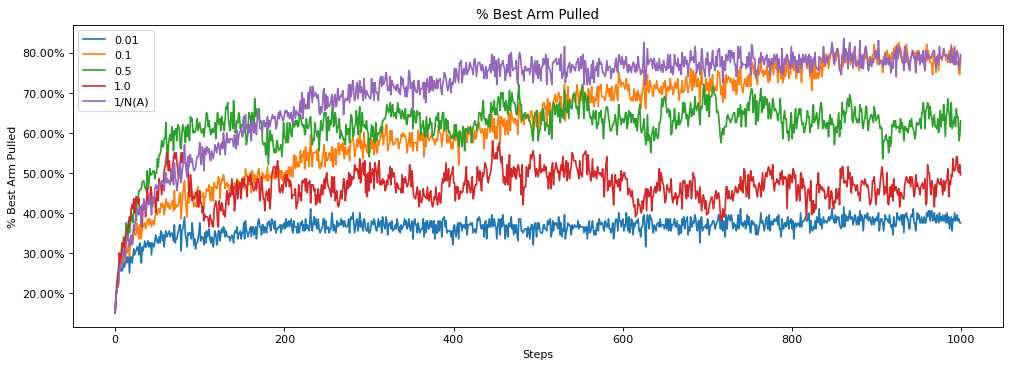

In [20]:
# ---------------
# Discussion Cell
# ---------------

# Experiment code for different step sizes
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()